## Problem Statement: The manager of a shop asked us to build a predictive model to forecast the number of sales for next week; The model must be run every Sunday and the result of the prediction must be reported on every Monday morning. Then, the manager can make a decision about the number of orders for the week. The manager then provides us the data of sales 811 products for 52 weeks


A time series is a sequence of observations taken sequentially in time. Time series forecasting involves taking models then fit them on historical data then using them to predict future observations. Therefore, for example, min(s), day(s), month(s), ago of the measurement is used as an input to predict the future

The steps that are considered to shift the data backward in the time(sequence), called lag times or lags. Therefore, a time series problem can be transformed into a supervised ML by adding lags of measurements as inputs of the supervised ML.

In [153]:
import numpy as np
import pandas as pd,gc
from sklearn import base

#Advance-style plotting
import seaborn as sns
color =sns.color_palette()
sns.set_style('darkgrid')

from matplotlib import pyplot as plt
#default data without encoding gave best score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings(action='once')

# DATA PREPARATION

In [154]:
products =pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
products_x = products.filter(regex=r'Product|W');products_x.head(2)

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0


In [155]:
products_x.shape

(811, 53)

# The data given has 811  product code and 52 weeks columns for sales. First, Lets create a new data frame by changing the data state/melting on the weeks. Thus, the new data frame has three columns, product code, week and sales. Besides, the “W” & “P” are dropped from the week and the product respectively. So, let’s take look at the head and the tail of the new data frame

Many data scientists might create a single model for each product to forecast the number of sales. And while this can work well, we may have problems due to having only 52 data points for each model, which is really low! Although this approach is possible, it might not the best solution. Besides, if there are interactions among the number of sales of two or more products, we might miss their interactions by building a single model for each product. Therefore, at this post, we will investigate how we can build a multiple time series forecasting models.

## Basic Feature Engineering

Let’s create two features which usually are used for time series. One step back in time, 1-lag(shift =1) and the difference between the number of purchase a week ago(W 1) and its previous week, means, two weeks ago (W2). After that, since the lag and diff result in having null in the dataset, see Fig. 4, we drop them. Therefore, when we look at the head of the data frame, it starts from week = 2.

In [156]:
products_x = products_x.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

In [157]:
products_x.head()

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8


In [160]:
products_x.shape

(42172, 3)

### Since we have melted out data down to weeks; now we have 3 columns 42172 observations..  lets do some analysis...

## UNIVARIATE ANALYSIS  1

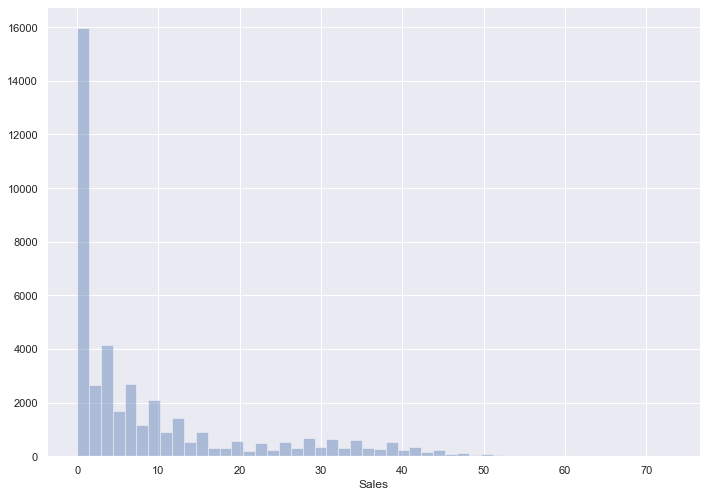

In [161]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(products_x['Sales'],kde = False)

Sales distribution. There are many product sales items with very low sales.

In [162]:
products_x['Product_Code'] =products_x.Product_Code.replace('[P]', '', regex =True)

In [163]:
products_x['Week'] =products_x['Week'] .replace({'W0':0, 'W1':1, 'W2':2, 'W3':3, 'W4':4, 'W5':5, 'W6':6, 'W7':7, 'W8':8, 'W9':9, 'W10':10,
       'W11':11, 'W12':12, 'W13':13, 'W14':14, 'W15':15, 'W16':16, 'W17':17, 'W18':18, 'W19':19,
       'W20':20, 'W21':21, 'W22':22, 'W23':23, 'W24':24, 'W25':25, 'W26':26, 'W27':27, 'W28':28,
      'W29':29, 'W30':30, 'W31':31, 'W32':32, 'W33':33, 'W34':34, 'W35':35, 'W36':36, 'W37':37,
       'W38':38, 'W39':39, 'W40':40, 'W41':41, 'W42':42, 'W43':43, 'W44':44, 'W45':45, 'W46':46,
       'W47':47, 'W48':48, 'W49':49 ,'W50':50, 'W51':51})

In [164]:
products_x.iloc[42171]

Product_Code    819
Week             51
Sales             1
Name: 42171, dtype: object

In [165]:
x=42172 
y=85965
products_x.loc[x:y]
products_x.loc[x:y].index
products_x.drop(products_x.loc[x:y].index, inplace=True)

In [166]:
products_x.dtypes

Product_Code    object
Week             int64
Sales            int64
dtype: object

In [167]:
products_x['Sales']=products_x['Sales'].astype(int)
products_x['Product_Code']=products_x['Product_Code'].astype(int)

In [169]:
products_x.isnull().sum()

Product_Code    0
Week            0
Sales           0
dtype: int64

In [170]:
products_x.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [171]:
class ToSupervised(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        
            
        return tmp

In [172]:

class ToSupervisedDiff(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_Week_Ago_Diff'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

Now, the data has a proper shape for using it at supervised ML.

# TIME SERIES KFOLD

In [173]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init,self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

Cross-Validation for Time Series
Cross-validation for time series is different from machine-learning problems that time or sequence is not involved. In the case of the absence of time, we select a random subset of data as a validation set to estimate the accuracy of the measurement. In time series, we often predict a value in the future. Therefore, the validation data always has to occur after the training data. There are two schemas sliding-window and Forward Chaining validation methods, that can be used for the time series CV

Forward-Chaining Cross-Validation:
The other problem when we are working on time series, we have to deal with its CV for time series. We chose forward-chaining for the model validation. To avoid having a very good model in a small number of weeks, we will use every week from 40 to 52, repeating the process for one at a time, and compute the score. Therefore, the k-fold code at this schema can be found at C. 3.

# Metric: RMSLE

In [174]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Baseline Estimator

In [175]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error

# TIME SERIES REGRESSOR

In [176]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [177]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

# TUNING

In [178]:
def getDataFramePipeline(i):
    steps = [(str(i)+'_step',ToSupervised('Sales','Product_Code',i))]
    for j in range(1,i+1):
        if i==j:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1,dropna=True))
            steps.append(pp)
        else:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1))
            steps.append(pp)
            
    return steps

In [179]:

from tqdm import tqdm
def stepsTune(X,model,num_steps,init=1):
    scores = []
    for i in tqdm(range(init,num_steps+1)):
        steps = []
        steps.extend(getDataFramePipeline(i))
        steps.append(('predic_1',model))
        super_ = Pipeline(steps).fit(X)
        score_ = np.mean(super_.score(X))
        scores.append((i,score_))
        
    return scores

# HYPERPARAMETER TUNING

In [180]:
from collections.abc import Mapping, Sequence, Iterable
from itertools import product
from functools import partial, reduce
import operator

class TimeGridBasic(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,param_grid):
        
    
        if not isinstance(param_grid, (Mapping, Iterable)):
                raise TypeError('Parameter grid is not a dict or '
                                'a list ({!r})'.format(param_grid))

        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]


        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]

        # check if all entries are dictionaries of lists
        for grid in param_grid:
            if not isinstance(grid, dict):
                raise TypeError('Parameter grid is not a '
                                'dict ({!r})'.format(grid))
            for key in grid:
                if not isinstance(grid[key], Iterable):
                    raise TypeError('Parameter grid value is not iterable '
                                    '(key={!r}, value={!r})'
                                    .format(key, grid[key]))


        self.param_grid = param_grid
                
    def __iter__(self):
        """Iterate over the points in the grid.
        Returns
        -------
        params : iterator over dict of string to any
            Yields dictionaries mapping each estimator parameter to one of its
            allowed values.
        """
        for p in self.param_grid:
            # Always sort the keys of a dictionary, for reproducibility
            items = sorted(p.items())
            if not items:
                yield {}
            else:
                keys, values = zip(*items)
                for v in product(*values):
                    params = dict(zip(keys, v))
                    yield params

In [181]:
class TimeSeriesGridSearch(TimeGridBasic,base.BaseEstimator, base.RegressorMixin):
    
    
    def __init__(self,**options):
        
        self.model      = options.pop('model', None)
        self.cv         = options.pop('cv', None)
        self.verbosity  = options.pop('verbosity', False)
        self.scoring    = options.pop('scoring', None)
        param_grid      = options.pop('param_grid', None)
        self.param_grid = TimeGridBasic(param_grid)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))

        if ((self.model==None )| (self.cv==None)):
            raise TypeError("Incomplete inputs")
            
            
    def fit(self,X,y=None):
        self.X = X
        return self


    def _get_score(self,param):

        errors = []
        for indx,fold in enumerate(self.cv.split(self.X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.set_params(**param).fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))
                
        
        return errors

    def score(self):

        errors=[]
        get_param = []
        for param in self.param_grid:
            
            if self.verbosity:
                print(param)
                
            errors.append(np.mean(self._get_score(param)))
            get_param.append(param)

        self.sorted_errors,self.sorted_params = (list(t) for t in zip(*sorted(zip(errors,get_param))))
        
        return self.sorted_errors,self.sorted_params
    
    
    def best_estimator(self,verbosity=False):

        if verbosity:
            print('error: {:.4f} \n'.format(self.sorted_errors[0]))
            print('Best params:')
            print(self.sorted_params[0])

        return self.sorted_params[0]

In [183]:
steps = [('1_step',
          ToSupervised('Sales','Product_Code',1)),
         ('1_step_diff',
          ToSupervisedDiff('1_Week_Ago_Sales',
          'Product_Code',1,dropna=True))]
sales_history = Pipeline(steps).fit_transform(products_x)

In [185]:
sales_history.isnull().sum()

Product_Code                        0
Week                                0
Sales                               0
1_Week_Ago_Sales                    0
1_Week_Ago_Diff_1_Week_Ago_Sales    0
dtype: int64

In [186]:
sales_history['Week']=sales_history['Week'].astype(int)
sales_history['Product_Code']=sales_history['Product_Code'].astype(int)
sales_history['1_Week_Ago_Sales']=sales_history['1_Week_Ago_Sales'].astype(int)
sales_history['1_Week_Ago_Diff_1_Week_Ago_Sales']=sales_history['1_Week_Ago_Diff_1_Week_Ago_Sales'].astype(int)

In [188]:
sales_history.head()

,Product_Code,Week,Sales,1_Week_Ago_Sales,1_Week_Ago_Diff_1_Week_Ago_Sales
0,1,2,10,12,1
1,2,2,3,6,-1
2,3,2,8,11,4
3,4,2,13,8,-4
4,5,2,13,5,-3


In [189]:
sales_history['1_Week_Ago_Diff_1_Week_Ago_Sales'].unique()

array([  1,  -1,   4,  -4,  -3,   0,  -2,  -5,  -8,  26,  -9,   5,  -7,
         6,   2, -10,  10,   3, -14, -15,  15, -11,  19,  22, -12,   8,
        -6,  17,  11,   7, -13,  25,  34,  18,   9,  12,  16,  13,  14,
       -19, -18,  20, -22, -16,  31,  24,  21, -20, -17, -21, -32,  23,
       -23, -24,  27, -26, -27, -25,  28, -33, -34, -30, -29,  29, -28],
      dtype=int64)

In [191]:
kf = Kfold_time(target='Sales',date_col = 'Week', 
                   date_init=40, date_final=52)

In [192]:
sales_history.isnull().sum()

Product_Code                        0
Week                                0
Sales                               0
1_Week_Ago_Sales                    0
1_Week_Ago_Diff_1_Week_Ago_Sales    0
dtype: int64

Since the problem is Regression, there are several well-known metrics to evaluate the model, such as Mean Square Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Root Mean Squared Log Error (RMSLE), R-squared, so forth. Each of these metrics has its own use case and they punish the error differently while there are some similarities among them as well. In this post, RMSLE is chosen to evaluate the model.

Baseline:
Usually, when we build a model, we might come up with a very simple assumption that we expect using ML can improve it. Here, let’s assume that the number of each product is sold at the current week, it will be the same for the next week. It means that if product-1 is sold 10 times at week-1, its sales number also will be the same for week-2. It generally is not a bad assumption. So, let’s consider this assumption as our baseline model.
The baseline model is coded at C. 5, let’s see how the baseline model works

In [193]:
#baseline model
base_model = BaseEstimator('1_Week_Ago_Sales')
errors = []
for indx,fold in enumerate(kf.split(sales_history)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

Fold: 0, Error: 0.520
Fold: 1, Error: 0.517
Fold: 2, Error: 0.510
Fold: 3, Error: 0.508
Fold: 4, Error: 0.534
Fold: 5, Error: 0.523
Fold: 6, Error: 0.500
Fold: 7, Error: 0.491
Fold: 8, Error: 0.506
Fold: 9, Error: 0.505
Fold: 10, Error: 0.522
Fold: 11, Error: 0.552
Total Error 0.516


Here, fold 0 to 11 indicate week = 40 to week = 52. The mean of RMSLE for the baseline model over these 12 weeks is 0.51. This can be considered as a big error which might originate from the huge number of items were sold very little amounts as shown

Machine Learning Models:
Now, we will apply the ML to improve the baseline prediction. Let’s define a Time Series Regressor Class, C. 5, which work with our time series cross-validation. This class gets the cv and model and it returns, the model prediction and its score. There is a wide range of ML algorithms that can be used as an estimator. Here, we select a Random Forest. Simply, RF can be considered as a combination of bagging and randomly selecting columns of features on top of decision trees. Therefore, it reduces the variance of the prediction of a decision tree model. So, it usually has better performance than a single tree and has weaker performance than ensemble methods which are designed to reduce the bias error of the decision tree model

# First Model - One Step
### RANDOM FOREST

In [195]:

model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
steps_1 = [('1_step',ToSupervised('Sales','Product_Code',1)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_1',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
sales_history_p = Pipeline(steps_1).fit(products_x)

In [196]:
Model_1_Error = sales_history_p.score(products_x)

Fold: 0, Error: 0.4624
Fold: 1, Error: 0.4596
Fold: 2, Error: 0.4617
Fold: 3, Error: 0.4666
Fold: 4, Error: 0.4712
Fold: 5, Error: 0.4310
Fold: 6, Error: 0.4718
Fold: 7, Error: 0.4494
Fold: 8, Error: 0.4608
Fold: 9, Error: 0.4470
Fold: 10, Error: 0.4746
Fold: 11, Error: 0.4865
Total Error 0.4619


It seems that the model works and the error decrease. Let’s add more lags and evaluate the model again. Since we built the pipeline, add more lags would be very simple.

# SECOND MODEL- FOUR STEP

In [198]:
steps_3 = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
sales_history_3p = Pipeline(steps_3).fit(products_x)

In [199]:
Model_3_Error = sales_history_3p.score(products_x)

Fold: 0, Error: 0.4312
Fold: 1, Error: 0.4385
Fold: 2, Error: 0.4274
Fold: 3, Error: 0.4194
Fold: 4, Error: 0.4479
Fold: 5, Error: 0.4070
Fold: 6, Error: 0.4395
Fold: 7, Error: 0.4333
Fold: 8, Error: 0.4387
Fold: 9, Error: 0.4305
Fold: 10, Error: 0.4591
Fold: 11, Error: 0.4534
Total Error 0.4355


It seems that the error of the prediction reduces again and the model learns more. We can continue to add lags and see how the performance of the model changes; however we will postpone this process until we use LGBM as an estimator.

Statistical Transformations:
The distribution of sales, Fig. 7 shows that the data skews toward the low sales number or to the left. Usually, Log transforms are useful when applied to skewed distributions as they tend to expand the values which fall in the range of lower magnitudes and tend to compress or reduce the values which fall in the range of higher magnitudes. The interpretability of the models changes when we do statistical transformations since the coefficients no more tell us about the original features but the transformed features. Therefore, while we apply np.log1p on the sales number to transform its distribution to become closer to the normal distribution, we also apply np.expm1 on the result of the prediction, see C. 6, TimeSeriesRegressorLog. Now, we repeat the calculation with the mentioned transformation

# CHANGE THE TARGET DISTRIBUTION

In [200]:
steps_3_log = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmsle))]
sales_history_3p_log = Pipeline(steps_3_log).fit(products_x)

In [201]:
Model_3_Log_Error = sales_history_3p_log.score(products_x)

Fold: 0, Error: 0.4168
Fold: 1, Error: 0.4221
Fold: 2, Error: 0.4125
Fold: 3, Error: 0.4035
Fold: 4, Error: 0.4332
Fold: 5, Error: 0.3977
Fold: 6, Error: 0.4263
Fold: 7, Error: 0.4122
Fold: 8, Error: 0.4301
Fold: 9, Error: 0.4375
Fold: 10, Error: 0.4462
Fold: 11, Error: 0.4727
Total Error 0.4259


This shows that the performance of the model improves and the error reduces again.

# LIGHTGBM MODEL

In [204]:
products_x['Week']=sales_history['Week'].astype(int)
products_x['Product_Code']=sales_history['Product_Code'].astype(int)
sales_history['1_Week_Ago_Sales']=sales_history['1_Week_Ago_Sales'].astype(int)
sales_history['1_Week_Ago_Diff_1_Week_Ago_Sales']=sales_history['1_Week_Ago_Diff_1_Week_Ago_Sales'].astype(int)


In [208]:
products_x.isnull().sum()

Product_Code    1622
Week            1622
Sales              0
dtype: int64

In [213]:
def rmsle(ytrue, ypred):
    sum=0.0
    for x in range(len(ypred)):
        if ypred[x]<0 or ytrue[x]<0: #check for negative values
            continue
        p = np.log(ypred[x]+1)
        r = np.log(ytrue[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(ypred))**0.5


Now, it is time to use a stronger ML estimator to improve forecasting. We chose LightGBM as a new estimator. So let’s repeat the calculation

In [214]:
model_lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
steps_3_log_lgbm = [('1_step',ToSupervised('Sales','Product_Code',3)),
         ('1_step_diff',ToSupervisedDiff('1_Week_Ago_Sales','Product_Code',1)),
         ('2_step_diff',ToSupervisedDiff('2_Week_Ago_Sales','Product_Code',1)),
         ('3_step_diff',ToSupervisedDiff('3_Week_Ago_Sales','Product_Code',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model_lgb ,cv=kf,scoring=rmsle))]
sales_historylog_lgbm = Pipeline(steps_3_log_lgbm).fit(products_x)

In [215]:
Model_3_Log_Error = sales_historylog_lgbm.score(products_x)

Fold: 0, Error: 0.3936
Fold: 1, Error: 0.3944
Fold: 2, Error: 0.4081
Fold: 3, Error: 0.3980
Fold: 4, Error: 0.3953
Fold: 5, Error: 0.3949
Fold: 6, Error: 0.4202
Fold: 7, Error: 0.3768
Fold: 8, Error: 0.4039
Fold: 9, Error: 0.3868
Fold: 10, Error: 0.3984
Fold: 11, Error: 0.4075
Total Error 0.3981


Again, we successfully improve the prediction

# Tuning Number of Steps

At this section, we are going to tune the number of steps (lags/diffs). I intentionally postpone tuning the steps this section after using LGBM as the regressor because it is faster than RF. Fig. 8 clearly shows that by adding more steps to the model the error reduces; however, as we expect, it is seen that after passing a threshold around steps = 14, adding further steps will not reduce the error significantly. You might be interested in defining an error threshold for stopping this process. Steps= 20 is chosen for the rest of the calculation. Please check code C 7. A and B for tuning.

In [216]:
model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
list_scores2 = stepsTune(products_x,
                         TimeSeriesRegressorLog(model=model_lgbm,scoring=rmsle,
                                           cv=kf,verbosity=False),20)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:31<00:00, 13.56s/it]


# PLOT

Text(0.5, 1.0, 'Steps Tuning')

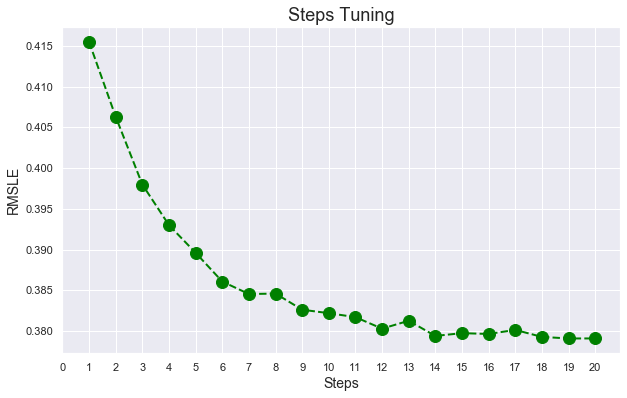

In [217]:

plt.figure(figsize=(10,6))
x = [i[0] for i in list_scores2]
y = [i[1] for i in list_scores2]
plt.plot(x,y,color='green', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(0, 21, step=1))
plt.xlabel('Steps',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Steps Tuning',fontsize=18)

In [218]:
# Tune Hyperparameters
params = {'n_estimators':[100,500,1000,1500,2000],
         'learning_rate':[0.005,.01,.1]}

steps_20 = getDataFramePipeline(20)
super_20 = Pipeline(steps_20).fit_transform(df)


model_lgbm2 = LGBMRegressor(random_state=0)
tune_lgbm =TimeSeriesGridSearch(model = model_lgbm2, cv = kf,param_grid=params,verbosity=False,scoring=rmsle)

In [219]:

tt = tune_lgbm.fit(super_20).score()

# Prediction vs. Real Sales

In [220]:
kf_51 = Kfold_time(target='Sales',date_col = 'Week',date_init=51,date_final=52)

In [221]:
best_param = tune_lgbm.best_estimator()
model_lgbmf = LGBMRegressor(**best_param,random_state=0)

T_51 = TimeSeriesRegressorLog(model=model_lgbmf ,scoring=rmsle,
                                             cv=kf_51,verbosity=False)
T_51.fit(super_20)
prediction_51 =T_51.predict(super_20)

In [222]:
prediction_51.head()

,0_fold
0,9.141751
1,4.073397
2,8.553865
3,8.546964
4,8.476343


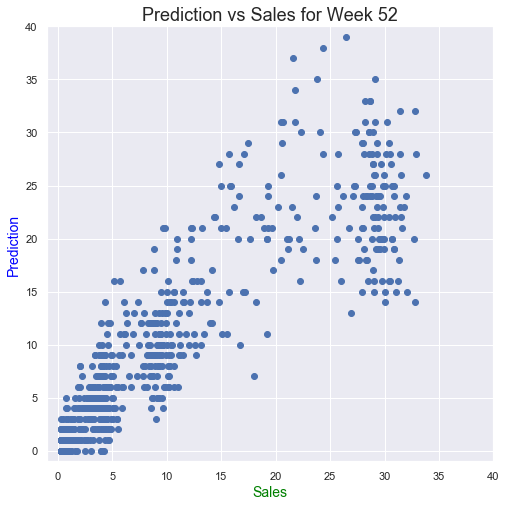

In [227]:

plt.figure(figsize=(8,8))
plt.scatter(prediction_51['0_fold'],df[df['Week']==51]['Sales'])
plt.xlabel('Sales',fontsize=14, color='green')
plt.ylabel('Prediction',fontsize=14,color='blue')
plt.xlim((-1,40))
plt.ylim((-1,40))
plt.title('Prediction vs Sales for Week 52',fontsize=18)
plt.show()

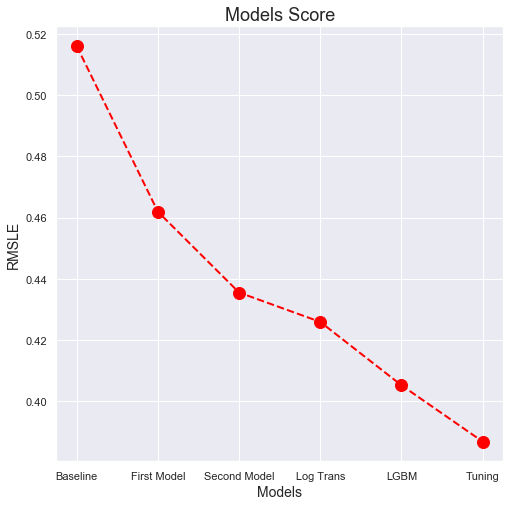

In [228]:
models=['Baseline','First Model','Second Model','Log Trans','LGBM','Tuning']
models_erros = [0.516,0.4619,0.4355,0.4259,0.4052,0.3868]
plt.figure(figsize=(8,8))
plt.plot(np.arange(6),models_erros,color='red', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(6), models)
plt.xlabel('Models',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Models Score',fontsize=18)
plt.show()

In [229]:
print('Error reduce: ',(0.516 - 0.3868)/0.516*100)

Error reduce:  25.038759689922486
